In [1]:
import sys; sys.path.append('..')
from feature_extraction import bow_occurrences, bow_tfidf, bow_tfidf_df
from preprocess_tweets import read_annotated_tweets, clean_tweets
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import os
from numpy import mean, std
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = read_annotated_tweets(os.path.abspath('../data/raw/england_italy_english_tweets.csv'))
clean_tweets(df)

Skipping line 182042: unexpected end of data


In [3]:

ngrams = bow_tfidf(df['tweet_text'], (1,2))

In [4]:
#print(ngrams)

X_train = ngrams[:298]
Y_train = df['label'].iloc[:298]

Y_test = ngrams[299:]

#print(ngrams.shape)
#print(X_train.shape)
#print(Y_test.shape)


In [5]:
mb_model = MultinomialNB()

mb_model.fit(X_train, Y_train)



MultinomialNB()

5012
2077
174652


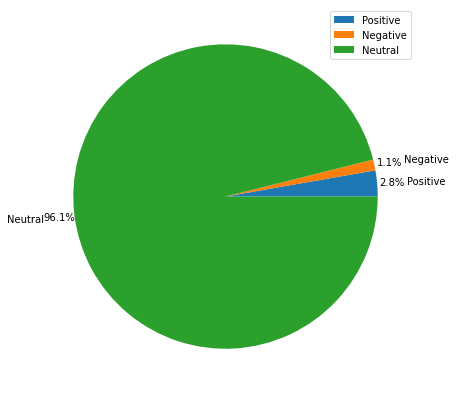

In [6]:
predicted = mb_model.predict(Y_test)

positives = list(filter(lambda x: str(x) == 'Positive', predicted))
negatives = list(filter(lambda x: str(x) == 'Negative', predicted))
neutrals = list(filter(lambda x: str(x) == 'Neutral', predicted))

print(len(positives))
print(len(negatives))
print(len(neutrals))

labels = ['Positive', 'Negative', 'Neutral']
sizes = [len(positives), len(negatives), len(neutrals)]

plt.pie(sizes, labels=labels, autopct='%.1f%%', pctdistance=1.1, labeldistance=1.2)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.savefig('../figs/match_sentiment_pie.png')
plt.show()

In [7]:
timestamps = df['timestamp'].iloc[299:].to_list()

#print(timestamps)

timestamp_label_df = pd.DataFrame(list(zip(timestamps, predicted)), columns=['timestamp', 'label'])

timestamp_label_df['timestamp'] = pd.to_datetime(timestamp_label_df['timestamp'])

print(timestamp_label_df)


                       timestamp    label
0      2021-07-11 18:07:01+00:00  Neutral
1      2021-07-11 18:07:02+00:00  Neutral
2      2021-07-11 18:06:58+00:00  Neutral
3      2021-07-11 18:06:57+00:00  Neutral
4      2021-07-11 18:07:00+00:00  Neutral
...                          ...      ...
181736 2021-07-11 22:41:38+00:00  Neutral
181737 2021-07-11 22:41:38+00:00  Neutral
181738 2021-07-11 22:41:38+00:00  Neutral
181739 2021-07-11 22:41:38+00:00  Neutral
181740 2021-07-11 22:41:39+00:00  Neutral

[181741 rows x 2 columns]


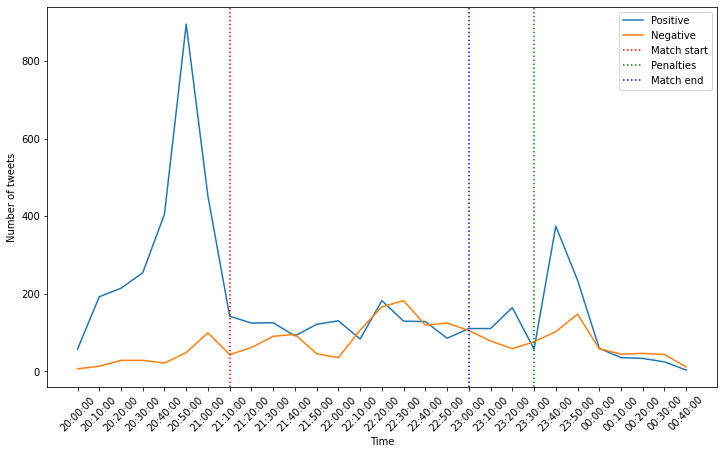

In [8]:
#timestamp_label_df = timestamp_label_df.set_index('timestamp')
timestamp_label_df['timestamp'] = timestamp_label_df['timestamp'].dt.tz_convert('Europe/Ljubljana')


positives_df = timestamp_label_df[timestamp_label_df["label"] == "Positive"]
negatives_df = timestamp_label_df[timestamp_label_df["label"] == "Negative"]
neutrals_df = timestamp_label_df[timestamp_label_df["label"] == "Neutral"]

grouped__pos_df = positives_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='10min')).count()
grouped__neg_df = negatives_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='10min')).count()
grouped__neu_df = neutrals_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='10min')).count()


""" print(grouped__pos_df.shape)
print(grouped__neg_df.shape)
print(grouped__neu_df.shape)

print(grouped__pos_df.iloc[-1])
print(grouped__neg_df.iloc[-1])
print(grouped__neu_df.iloc[-1]) """

#print(grouped__pos_df.index)

dates = [x.strftime("%H:%M:%S") for x in grouped__pos_df.index]


plt.figure(figsize=(12,7))
plt.plot(dates, grouped__pos_df['label'], label='Positive')
plt.plot(dates, grouped__neg_df['label'], label='Negative')
#plt.plot(dates, grouped__neu_df['label'], label='Neutral')
plt.xlabel('Time')
plt.ylabel('Number of tweets')
plt.xticks(rotation=45)
plt.axvline(dates[7], color='r', label="Match start", linestyle=':')
plt.axvline(dates[21], color='g', label="Penalties", linestyle=':')
plt.axvline(dates[18], color='b', label="Match end", linestyle=':')
plt.legend()
plt.savefig("../figs/match_sentiment.png")
plt.show()

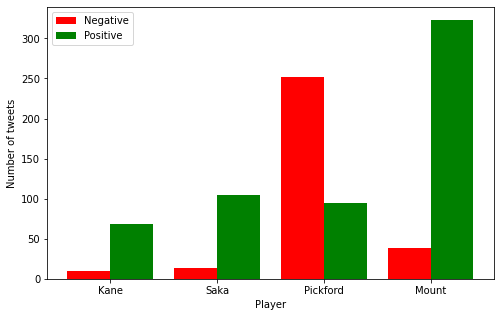

In [41]:


text_label_df = pd.DataFrame(list(zip(df['tweet_text'].iloc[299:].to_list(), predicted)), columns=['tweet_text', 'label'])
kane_df = text_label_df[text_label_df['tweet_text'].str.contains("kane")==True]
bonucci_df = text_label_df[text_label_df['tweet_text'].str.contains("bonuci|bonucci")==True]
sterling_df = text_label_df[text_label_df['tweet_text'].str.contains("sterling")==True]
saka_df = text_label_df[text_label_df['tweet_text'].str.contains("saka")==True]
donnaruma_df = text_label_df[text_label_df['tweet_text'].str.contains("donnaruma|donaruma")==True]
mount_df = text_label_df[text_label_df['tweet_text'].str.contains("mount")==True]
pickford_df = text_label_df[text_label_df['tweet_text'].str.contains("pickford")==True]

kane_positives = list(filter(lambda x: str(x) == 'Positive', kane_df['label'].to_list()))
kane_negatives = list(filter(lambda x: str(x) == 'Negative', kane_df['label'].to_list()))

saka_positives = list(filter(lambda x: str(x) == 'Positive', saka_df['label'].to_list()))
saka_negatives = list(filter(lambda x: str(x) == 'Negative', saka_df['label'].to_list()))

pickford_positives = list(filter(lambda x: str(x) == 'Positive', pickford_df['label'].to_list()))
pickford_negatives = list(filter(lambda x: str(x) == 'Negative', pickford_df['label'].to_list()))

mount_positives = list(filter(lambda x: str(x) == 'Positive', mount_df['label'].to_list()))
mount_negatives = list(filter(lambda x: str(x) == 'Negative', mount_df['label'].to_list()))

positives = [len(kane_positives), len(saka_positives), len(pickford_positives), len(mount_positives)]
negatives = [len(kane_negatives), len(saka_negatives), len(pickford_negatives), len(mount_negatives)]

labels = ['Kane', 'Saka', 'Pickford', 'Mount']

x = np.arange(len(labels))
width = 0.4
plt.figure(figsize=(8,5))
plt.bar(x - 0.2, positives, label='Positive', color='g', width=width)
plt.bar(x + 0.2, negatives, label='Negative', color='r', width=width)
plt.xticks(x, labels)
plt.ylabel('Number of tweets')
plt.xlabel('Player')
plt.legend()
plt.savefig('../figs/players_sentiment.png')
plt.show()


